In [1]:
import json
import yaml
import datetime as dt
import time

import matplotlib.pyplot as plt
import torch
import IPython.display as ipd

from gradtts import GradTTS
from gradseptts import GradSepTTS
from gradtfktts import GradTFKTTS

import toybox

In [2]:
def convert_phn_to_id(phonemes, phn2id):
    """
    phonemes: phonemes separated by ' '
    phn2id: phn2id dict
    """
    return [phn2id[x] for x in ['<bos>'] + phonemes.split(' ') + ['<eos>']]

def text2phnid(text, phn2id, language='en', add_blank=True):
    if language=='en':
        from text import G2pEn
        word2phn = G2pEn()
        phonemes = word2phn(text)
        if add_blank:
            phonemes = ' <blank> '.join(phonemes)
        return phonemes, convert_phn_to_id(phonemes, phn2id)
    else:
        raise ValueError(
            'Language should be en (for English)!')

In [3]:
def plot_mel(tensors, titles):
    xlim = max([t.shape[1] for t in tensors])
    fig, axs = plt.subplots(nrows=len(tensors),
                            ncols=1,
                            figsize=(12, 9),
                            constrained_layout=True)
    if len(tensors) == 1:
        axs = [axs]
    
    for i in range(len(tensors)):
        im = axs[i].imshow(tensors[i],
                           aspect="auto",
                           origin="lower",
                           interpolation='none')
        plt.colorbar(im, ax=axs[i])
        axs[i].set_title(titles[i])
        axs[i].set_xlim([0, xlim])
    fig.canvas.draw()
    return plt

In [4]:
# Setup HiFi-GAN

from hifigan import models, env

# from https://github.com/huawei-noah/Speech-Backbones/tree/main/Grad-TTS/hifi-gan
# https://drive.google.com/drive/folders/1-eEYTB5Av9jNql0WGBlRoi-WH2J7bp5Y?usp=sharing
HiFiGAN_CONFIG = './hifigan/official_pretrained/LJ_V2/config.json'
HiFiGAN_ckpt = './hifigan/official_pretrained/LJ_V2/generator_v2'

with open(HiFiGAN_CONFIG) as f:
    hifigan_hparams = env.AttrDict(json.load(f))

generator = models.Generator(hifigan_hparams)

generator.load_state_dict(torch.load(
    HiFiGAN_ckpt, map_location='cpu')['generator'])
generator = generator.eval()
generator.remove_weight_norm()


def convert_mel_to_audio(mel):
    # only support batch size of 1
    assert mel.shape[0] == 1
    with torch.no_grad():
        audio = generator(mel).squeeze(1)  # (b,t)
    """
    At Speech-Backbones's inference.ipynb
    with torch.no_grad():
        audio = hifigan.forward(y_dec).cpu().squeeze().clamp(-1, 1)
    """
    return audio


/work/sora-sa/aoi/.venv/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


In [10]:
# inference for ljspeech

N_SPKS = 109
N_STEP = 50 #4
TEMP = 1.3 #1.5
STREAMING_CLIP_SIZE = 0.5  # in seconds

#config_path = 'config/ljspeech_config.yaml'
config_path = 'configs/config_sgt_k3.yaml'
ckpt_path = 'logs4model/gradseptts/run_test_sgt_k3/ckpt/gradseptts_1000_794003.pt'

#config_path = 'configs/config_gt_k3.yaml'
#ckpt_path = './grad_360.pt'

print('loading ', ckpt_path)
_, _, state_dict = torch.load(ckpt_path,
                              map_location='cpu')


#with open(config_path) as f:
#    config = yaml.load(f, yaml.SafeLoader)
config = toybox.load_yaml_and_expand_var(config_path)
model_name = config["model_name"]


with open(config['phn2id_path']) as f:
    phn2id = json.load(f)
vocab_size = len(phn2id) + 1

print("Initializing model...")
if model_name == "gradtts":
    model = GradTTS.build_model(config, vocab_size)
elif model_name == "gradseptts":
    model = GradSepTTS.build_model(config, vocab_size)
elif model_name == "gradtfktts":
    model = GradTFKTTS.build_model(config, vocab_size)
else:
    raise ValueError(f"Error: '{model_name}' is not supported")

#model = GradTTS.build_model(config, vocab_size)
model.load_state_dict(state_dict)

loading  logs4model/gradseptts/run_test_sgt_k3/ckpt/gradseptts_1000_794003.pt
Initializing model...


<All keys matched successfully>

In [16]:
text = "Let's keep up the good work on Speech research!"

phonemes, phnid = text2phnid(text, phn2id, 'en')
print(f'phoneme seq: {phonemes}', type(phonemes))
phnid_len = torch.tensor(len(phnid), dtype=torch.long).unsqueeze(0)
phnid = torch.tensor(phnid).unsqueeze(0)


phoneme seq: L <blank> EH1 <blank> T <blank> S <blank> - <blank> K <blank> IY1 <blank> P <blank> - <blank> AH1 <blank> P <blank> - <blank> DH <blank> AH0 <blank> - <blank> G <blank> UH1 <blank> D <blank> - <blank> W <blank> ER1 <blank> K <blank> - <blank> AA1 <blank> N <blank> - <blank> S <blank> P <blank> IY1 <blank> CH <blank> - <blank> R <blank> IY0 <blank> S <blank> ER1 <blank> CH <blank> ! <class 'str'>


In [6]:
#start_time = time.perf_counter()
t=dt.datetime.now()
_, mel_prediction, _ = model.forward(
    phnid,
    phnid_len,
    spk=N_SPKS,
    n_timesteps=N_STEP,
    temperature=TEMP,
    solver="original"
)
t = (dt.datetime.now() - t).total_seconds()
#end_time = time.perf_counter()
#dt = end_time - start_time
print(f'{model_name} RTF: {t * 22050 / ( mel_prediction.shape[-1] * 256)}')
# from espnet https://colab.research.google.com/github/espnet/notebook/blob/master/ESPnet2/Demo/TTS/tts_realtime_demo.ipynb
#rtf = (time.time() - start) / (len(wav) / text2speech.fs)
#print(f"RTF = {rtf:5f}")

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1867797680.py, line 6)

In [33]:
mel_prediction.shape

torch.Size([1, 80, 281])

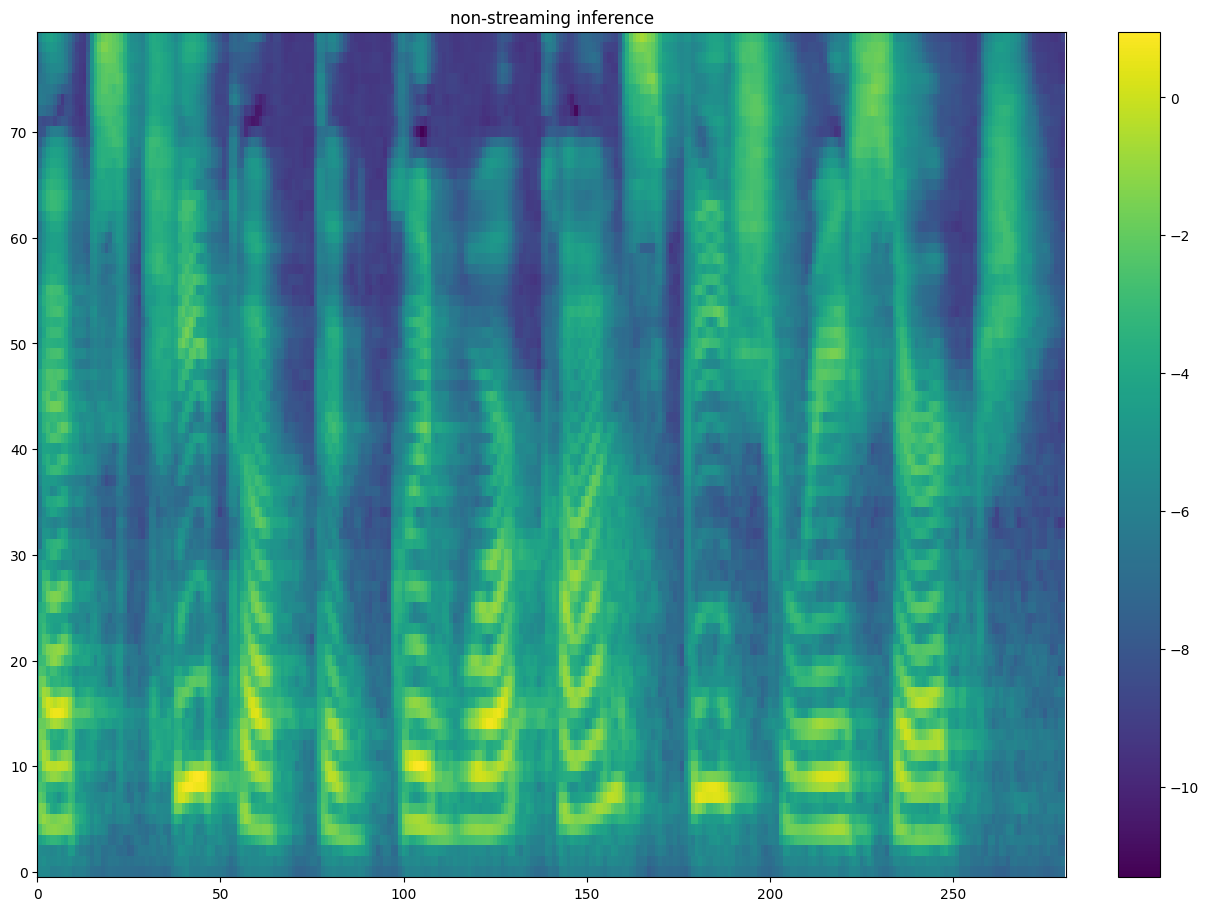

In [18]:
#plot_mel([mel_prediction_streaming[0], mel_prediction[0]],
#         ['streaming inference', 'non-streaming inference'])
plot_mel([mel_prediction[0]],
        ['non-streaming inference'])
ipd.display(ipd.Audio(convert_mel_to_audio(mel_prediction), rate=22050))

In [ ]:
"""

# from espnet2_tts_demo
# https://github.com/espnet/espnet
# https://colab.research.google.com/github/espnet/notebook/blob/master/ESPnet2/Demo/TTS/tts_realtime_demo.ipynb#scrollTo=vrRM57hhgtHy

import time
import torch

# decide the input sentence by yourself
print(f"Input your favorite sentence in {lang}.")
x = input()

# synthesis
with torch.no_grad():
    start = time.time()
    wav = text2speech(x)["wav"]
rtf = (time.time() - start) / (len(wav) / text2speech.fs)
print(f"RTF = {rtf:5f}")

# let us listen to generated samples
from IPython.display import display, Audio
display(Audio(wav.view(-1).cpu().numpy(), rate=text2speech.fs))

"""

In [ ]:
"""
N_SPKS = 1  # 247 for Libri-TTS model and 1 for single speaker (LJSpeech)
t = dt.datetime.now()
y_enc, y_dec, attn = generator.forward(x, x_lengths, n_timesteps=50, temperature=1.3,
                                       stoc=False, spk=None if N_SPKS==1 else torch.LongTensor([15]).cuda(),
                                       length_scale=0.91)
t = (dt.datetime.now() - t).total_seconds()
print(f'Grad-TTS RTF: {t * 22050 / (y_dec.shape[-1] * 256)}')
"""